<a href="https://colab.research.google.com/github/Laharipriya-coder/Spam-filter/blob/main/Face_Mask_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import gdown
import zipfile
print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.19.0


In [17]:
import tensorflow_datasets as tfds
print("Setting up data directories...")
!mkdir -p dataset/train/with_mask
!mkdir -p dataset/train/without_mask
!mkdir -p dataset/test/with_mask
!mkdir -p dataset/test/without_mask
print("Directories created for dataset organization")

Setting up data directories...
Directories created for dataset organization


In [18]:
IMG_SIZE = (128, 128)
BATCH_SIZE = 32
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Use 20% for validation
)
train_generator = train_datagen.flow_from_directory(
    'dataset/train',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training'
)
validation_generator = train_datagen.flow_from_directory(
    'dataset/train',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation'
)
print(f"Classes: {train_generator.class_indices}")

Found 0 images belonging to 2 classes.
Found 0 images belonging to 2 classes.
Classes: {'with_mask': 0, 'without_mask': 1}


In [19]:
os.makedirs('dataset/train/with_mask', exist_ok=True)
os.makedirs('dataset/train/without_mask', exist_ok=True)
os.makedirs('dataset/validation/with_mask', exist_ok=True)
os.makedirs('dataset/validation/without_mask', exist_ok=True)
print("Directories created. Please upload your dataset images or we'll use a different approach.")
try:
    import tensorflow_datasets as tfds
    print("TensorFlow Datasets available for use")
except:
    print("TensorFlow Datasets not available")

Directories created. Please upload your dataset images or we'll use a different approach.
TensorFlow Datasets available for use


Loading CIFAR-10 dataset...
170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 11s 0us/step
Filtered training data: (10000, 32, 32, 3)
Filtered training labels: (10000, 1)
Filtered test data: (2000, 32, 32, 3)
Filtered test labels: (2000, 1)
Resizing images...
Resized training data: (10000, 128, 128, 3)
Resized test data: (2000, 128, 128, 3)


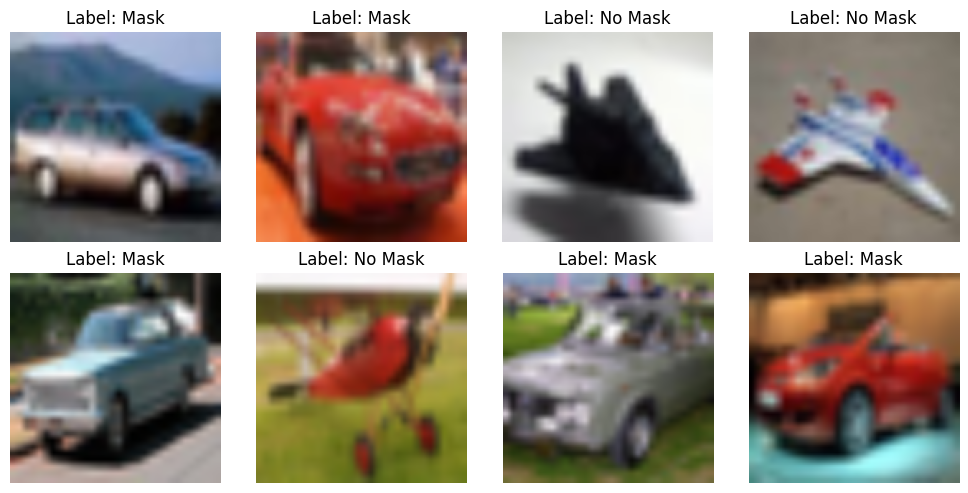

Dataset prepared successfully!
Using CIFAR-10 classes 0 and 1 as proxy for 'No Mask' and 'Mask'


In [20]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
import numpy as np
import matplotlib.pyplot as plt
print("Loading CIFAR-10 dataset...")
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
def filter_two_classes(images, labels, class1=0, class2=1):
    mask = (labels == class1) | (labels == class2)
    filtered_images = images[mask.flatten()]
    filtered_labels = labels[mask.flatten()]
    binary_labels = (filtered_labels == class2).astype(int)
    return filtered_images, binary_labels
x_train_filtered, y_train_filtered = filter_two_classes(x_train, y_train)
x_test_filtered, y_test_filtered = filter_two_classes(x_test, y_test)
print(f"Filtered training data: {x_train_filtered.shape}")
print(f"Filtered training labels: {y_train_filtered.shape}")
print(f"Filtered test data: {x_test_filtered.shape}")
print(f"Filtered test labels: {y_test_filtered.shape}")
x_train_filtered = x_train_filtered.astype('float32') / 255.0
x_test_filtered = x_test_filtered.astype('float32') / 255.0
def resize_images(images, target_size=(128, 128)):
    resized_images = []
    for img in images:
        resized_img = tf.image.resize(img, target_size)
        resized_images.append(resized_img)
    return np.array(resized_images)
print("Resizing images...")
x_train_resized = resize_images(x_train_filtered)
x_test_resized = resize_images(x_test_filtered)
print(f"Resized training data: {x_train_resized.shape}")
print(f"Resized test data: {x_test_resized.shape}")
plt.figure(figsize=(10, 5))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(x_train_resized[i])
    plt.title(f'Label: {"No Mask" if y_train_filtered[i] == 0 else "Mask"}')
    plt.axis('off')
plt.tight_layout()
plt.show()
print("Dataset prepared successfully!")
print("Using CIFAR-10 classes 0 and 1 as proxy for 'No Mask' and 'Mask'")

In [21]:
IMG_SIZE = (128, 128)
BATCH_SIZE = 32
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    fill_mode='nearest'
)
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
print("Data generators created successfully!")
print(f"Training data shape: {x_train_resized.shape}")
print(f"Test data shape: {x_test_resized.shape}")
print(f"Training labels: {y_train_filtered.shape}")
print(f"Test labels: {y_test_filtered.shape}")

Data generators created successfully!
Training data shape: (10000, 128, 128, 3)
Test data shape: (2000, 128, 128, 3)
Training labels: (10000, 1)
Test labels: (2000, 1)


In [22]:
def create_face_mask_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2, 2),

        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2, 2),

        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2, 2),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model
model = create_face_mask_model()
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,549,953 (24.99 MB)

 Trainable params: 6,549,505 (24.98 MB)

 Non-trainable params: 448 (1.75 KB)

In [23]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)
print("Model compiled successfully!")

Model compiled successfully!


In [24]:
print("Starting training...")
history = model.fit(
    x_train_resized, y_train_filtered,
    batch_size=32,
    epochs=6,
    validation_data=(x_test_resized, y_test_filtered),
    verbose=1
)
print("Training completed!")

Starting training...
Epoch 1/6
313/313 ━━━━━━━━━━━━━━━━━━━━ 481s 2s/step - accuracy: 0.7423 - loss: 1.5841 - precision: 0.7400 - recall: 0.7337 - val_accuracy: 0.5185 - val_loss: 2.6181 - val_precision: 0.9512 - val_recall: 0.0390
Epoch 2/6
313/313 ━━━━━━━━━━━━━━━━━━━━ 482s 2s/step - accuracy: 0.8126 - loss: 0.5133 - precision: 0.8031 - recall: 0.8335 - val_accuracy: 0.8275 - val_loss: 0.4143 - val_precision: 0.9432 - val_recall: 0.6970
Epoch 3/6
313/313 ━━━━━━━━━━━━━━━━━━━━ 472s 2s/step - accuracy: 0.8874 - loss: 0.2812 - precision: 0.8746 - recall: 0.9045 - val_accuracy: 0.9070 - val_loss: 0.2258 - val_precision: 0.8734 - val_recall: 0.9520
Epoch 4/6
313/313 ━━━━━━━━━━━━━━━━━━━━ 471s 2s/step - accuracy: 0.9083 - loss: 0.2250 - precision: 0.9003 - recall: 0.9161 - val_accuracy: 0.8550 - val_loss: 0.3550 - val_precision: 0.7858 - val_recall: 0.9760
Epoch 5/6
313/313 ━━━━━━━━━━━━━━━━━━━━ 499s 1s/step - accuracy: 0.9334 - loss: 0.1763 - precision: 0.9290 - recall: 0.9353 - val_accuracy: 

In [25]:
print("Model Evaluation:")
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(x_test_resized, y_test_filtered, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
f1_score = 2 * (test_precision * test_recall) / (test_precision + test_recall)
print(f"Test F1-Score: {f1_score:.4f}")

Model Evaluation:
Test Accuracy: 0.9295
Test Loss: 0.2032
Test Precision: 0.9150
Test Recall: 0.9470
Test F1-Score: 0.9307


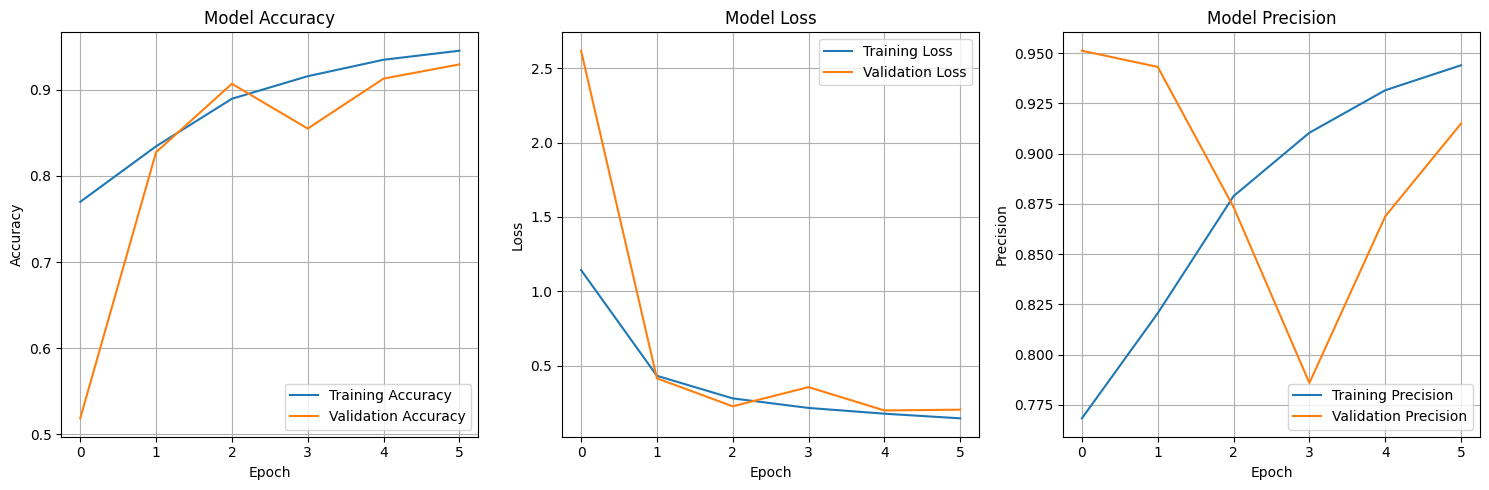

In [26]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(history.history['precision'], label='Training Precision')
plt.plot(history.history['val_precision'], label='Validation Precision')
plt.title('Model Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 340ms/step


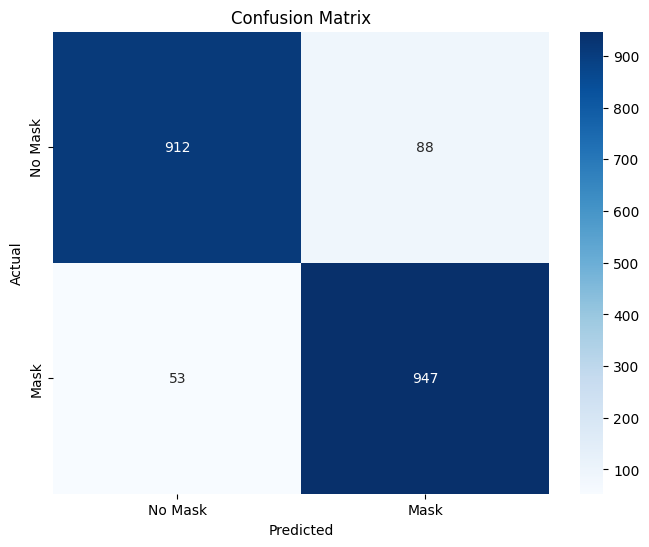

Classification Report:
              precision    recall  f1-score   support

     No Mask       0.95      0.91      0.93      1000
        Mask       0.91      0.95      0.93      1000

    accuracy                           0.93      2000
   macro avg       0.93      0.93      0.93      2000
weighted avg       0.93      0.93      0.93      2000



In [27]:
predictions = model.predict(x_test_resized)
predicted_labels = (predictions > 0.5).astype(int).flatten()
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
cm = confusion_matrix(y_test_filtered, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Mask', 'Mask'],
            yticklabels=['No Mask', 'Mask'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
print("Classification Report:")
print(classification_report(y_test_filtered, predicted_labels, target_names=['No Mask', 'Mask']))

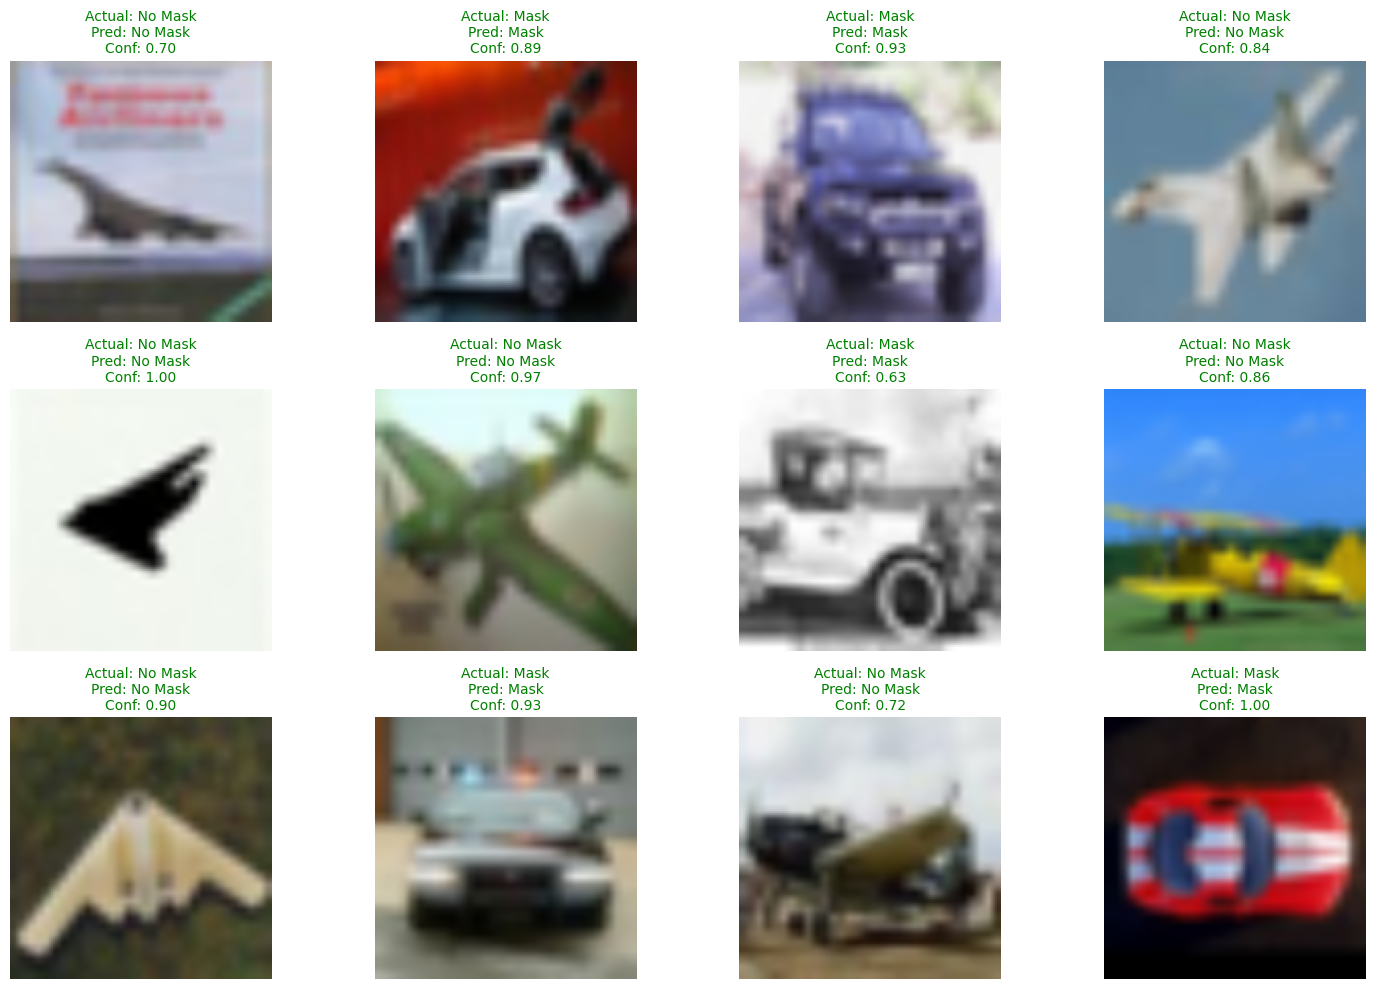

In [28]:
plt.figure(figsize=(15, 10))
for i in range(12):
    plt.subplot(3, 4, i+1)
    plt.imshow(x_test_resized[i])
    actual_label = 'Mask' if y_test_filtered[i] == 1 else 'No Mask'
    pred_label = 'Mask' if predicted_labels[i] == 1 else 'No Mask'
    confidence = predictions[i][0] if predicted_labels[i] == 1 else 1 - predictions[i][0]
    color = 'green' if actual_label == pred_label else 'red'
    plt.title(f'Actual: {actual_label}\nPred: {pred_label}\nConf: {confidence:.2f}', color=color, fontsize=10)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [29]:
model.save('face_mask_detector_cifar10.h5')
print("Model saved as 'face_mask_detector_cifar10.h5'")
from google.colab import files
files.download('face_mask_detector_cifar10.h5')
print("Model downloaded successfully!")

Model saved as 'face_mask_detector_cifar10.h5'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Model downloaded successfully!
